In [2]:
from langgraph.graph import StateGraph, START, END
# from langgraph.graph.message import add_messages 
from langchain_ollama import OllamaLLM
import json

from langchain_core.pydantic_v1 import Field 
from state import FinanceAgentState
from rich.console import Console
from rich.markdown import Markdown as RichMarkdown

d:\d_drive_coding\Agents\financial_analyst_langgraph\venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


Import the nodes/workflows  

In [3]:
# individual nodes (need to create separate scripts, defined here for debugging/demo purposes)
from workflows.get_stock_data_and_chart import get_stock_data_and_chart_node
from workflows.get_financial_news import get_financial_news_node
from workflows.curate_report import curate_report_node
from workflows.get_sec_filing_section import get_sec_filing_section_node
from workflows.extract_entities import extract_entities_node


✅ python-docx library loaded successfully


In [4]:


#  1
try:
    llm = OllamaLLM(model="llama3", format="json")
except Exception as e: 
    print(f"Error initialising Ollama. Is the Ollama server running? Error : {e}")



In [5]:
console = Console()

In [6]:

def check_for_chart_keywords(query: str) -> bool:
    """Checks the user query for keywords indicating a chart or plot is requested."""
    query = query.lower()
    return any(keyword in query for keyword in ["chart", "plot", "graph", "visualize", "visualise"])


# intent classification logic 
def classify_intent(state: FinanceAgentState) -> dict:
    """
    This is the "brain" of the application. It uses the LLM in JSON mode
    to classify the user's query into a specific intent.
    """
    print("---NODE: Classifying Intent---")
    user_query = state["user_query"]

    # The prompt now includes format instructions from the parser
    few_shot_prompt = f"""You are an expert at routing a user's query about financial analysis to the correct tool.
Your only job is to return a JSON object with a single key, "step", which indicates the correct tool to use.

The available tools are:
- get_sec_filing_section
- get_financial_news
- get_report
- greeting_help
- get_stock_data_and_chart  

Here are some examples of queries and their correct JSON output:

Queries for "get_sec_filing_section":
- Query: What were the business risks listed in Apple's (AAPL) most recent 10-K?
- JSON: {{"step": "get_sec_filing_section"}}
- Query: Can you get me the "Risk Factors" section from Meta's latest annual report?
- JSON: {{"step": "get_sec_filing_section"}}

Queries for "get_financial_news":
- Query: Summarize recent news about Tesla (TSLA).
- JSON: {{"step": "get_financial_news"}}
- Query: Any recent articles about leadership changes at Johnson & Johnson (JNJ)?
- JSON: {{"step": "get_financial_news"}}

Queries for "get_report":
- Query: Generate a full analyst report for Salesforce (CRM).
- JSON: {{"step": "get_report"}}
- Query: I need a detailed overview of Microsoft's (MSFT) financials and risks.
- JSON: {{"step": "get_report"}}

Queries for "greeting_help":
- Query: Hello, can you help me?
- JSON: {{"step": "greeting_help"}}
- Query: How do I use this?
- JSON: {{"step": "greeting_help"}}

Queries for "get_stock_data_and_chart":
- Query: What is the current P/E ratio for NVIDIA (NVDA)?
- JSON: {{"step": "get_stock_data_and_chart"}}
- Query: Give me a financial summary for Intel (INTC).
- JSON: {{"step": "get_stock_data_and_chart"}}
- Query: Show me a stock chart for Google (GOOGL) over the last year.
- JSON: {{"step": "get_stock_data_and_chart"}}
- Query: Plot the stock performance of Amazon (AMZN) for 2024.
- JSON: {{"step": "get_stock_data_and_chart"}}

---
Now, based on the user's query below, provide the JSON object. You **MUST** only choose from the available tools listed above. If the query does not match any of the tools or is ambiguous, return "{{"step": "greeting_help"}}".

Query: {user_query}
JSON:
"""
    print("---Checking INTENT CLASSIFICATION---")
    response_str = llm.invoke(few_shot_prompt)
    # ----- DEBUG ------ 
    print(f"---LLM RAW OUTPUT:---\n{response_str}\n--------------------")
    
    try:
        # We now use Python's built-in json library to parse the string
        decision_json = json.loads(response_str)
        intent = decision_json["step"]
    except Exception as e:
        # If parsing fails, fall back to a default intent
        print(f"---ERROR: Could not parse LLM output. Error: {e}---\nFalling back to default node - 'greeting_help'")
        intent = "greeting_help"

    updates = {"intent": intent}

    if intent == "get_stock_data_and_chart":
        is_chart_requested = check_for_chart_keywords(user_query)
        updates["create_chart"] = is_chart_requested  
        print(f"---INFO: Chart flag set to {is_chart_requested}---")

    return updates 

# --- 4. Router Function ---

# main router function 
def route_by_intent(state: FinanceAgentState) -> str:
    """
    Reads the 'intent' from the state and returns the name of the
    next node to run. This is the core of our conditional routing.
    """
    intent = state["intent"]
    print(f"---ROUTING: Intent is '{intent}'---")

    if intent == "get_stock_data_and_chart":
        return "get_stock_data_and_chart"
    elif intent == "get_financial_news":
        return "get_financial_news"
    elif intent == "get_report":
        return "get_stock_data_and_chart_for_report"
    elif intent == "get_sec_filing_section":
        return "get_sec_filing_section"
    else:
        # A fallback in case of an unexpected 
        print("❗Unexpected intent...routing back to continue_or_exit.")
        return "continue_or_exit"

# below are the follow up nodes 

# greeting_help.py

def greeting_help_node(state: FinanceAgentState) -> dict:     # simple greeting 
    
    print("---NODE: Providing Greeting/Help---")
    
    instructions = (
        """
     Hello! 😉
     
     I am FinSight 💰📈 - your personal Financial Analyst ...   

        Here are some things you can ask me to do 👇
        - Generate a stock performance chart for **Amazon (AMZN)**.
        - What are the risks listed in Microsoft's latest 10-K filing?
        - Summarize recent news about Tesla (TSLA).
        - What is the current P/E ratio for NVIDIA (NVDA)?
        - Generate a full analyst report for Salesforce (CRM).


        """
    )

    console.print(RichMarkdown(instructions))
    
    return {"final_answer": instructions}

def continue_or_exit_node(state: FinanceAgentState) -> dict:
    """
    Prompts the user for the next query, capturing input, and setting the
    'should_continue' flag for the 'follow_up_router'.
    """

    print("\n--- Awaiting Next Query ---")
    while True:
        user_input = input(" -> Your Question (or type 'exit' to quit): ")
        
        if user_input.lower() == 'exit':
            return {"should_continue": False}
        else:
           
            return {"user_query": user_input, "should_continue": True}


# follow-up router function 
def route_follow_up1(state: FinanceAgentState) -> str:
    """
    Reads the 'should_continue' flag from the state and returns the
    next node to run. Routes directly to extract_entities for the next turn.
    """
    should_continue = state["should_continue"]
    
    print(f"---FOLLOW-UP ROUTING: ", 
          f"\nUser wants to continue = '{should_continue}'" if should_continue else "\nUser wants to EXIT = '{should_continue}'", 
          "---")

    if should_continue:
        return "extract_entities"
    else:
        return END

# follow-up router function 
def route_follow_up2(state: FinanceAgentState) -> str:
    """
    Reads the 'should_continue' flag from the state and returns the
    next node to run. Routes directly to greeting_help for the next turn.
    """
    should_continue = state["should_continue"]
    
    print(f"---FOLLOW-UP ROUTING: ", 
          f"\nUser wants to continue = '{should_continue}'" if should_continue else "\nUser wants to EXIT = '{should_continue}'", 
          "---")

    if should_continue:
        return "extract_entities"
    else:
        return END
    



### Graph definition and compilation

In [7]:

graph_builder = StateGraph(FinanceAgentState)

graph_builder.add_node("greeting_help", greeting_help_node)
graph_builder.add_node("continue_or_exit1", continue_or_exit_node)  # use router1
graph_builder.add_node("extract_entities", extract_entities_node)  
graph_builder.add_node("classify_intent", classify_intent)
graph_builder.add_node("get_stock_data_and_chart", get_stock_data_and_chart_node)
graph_builder.add_node("get_financial_news", get_financial_news_node)
graph_builder.add_node("get_sec_filing_section", get_sec_filing_section_node)


# get report 
graph_builder.add_node("get_stock_data_and_chart_for_report", get_stock_data_and_chart_node)
graph_builder.add_node("get_financial_news_for_report", get_financial_news_node)
graph_builder.add_node("get_sec_filing_section_for_report", get_sec_filing_section_node)
graph_builder.add_node("curate_report", curate_report_node)
graph_builder.add_node("continue_or_exit2", continue_or_exit_node)  # use router 2 

# orchestrate

graph_builder.add_edge(START, "greeting_help")



graph_builder.add_edge("greeting_help", "continue_or_exit1")
graph_builder.add_conditional_edges(
    "continue_or_exit1",
    route_follow_up1,
)

graph_builder.add_edge("extract_entities", "classify_intent")
graph_builder.add_conditional_edges(
    "classify_intent",
    route_by_intent,
)

graph_builder.add_edge("get_stock_data_and_chart", "continue_or_exit2")
graph_builder.add_edge("get_financial_news", "continue_or_exit2")
graph_builder.add_edge("get_sec_filing_section", "continue_or_exit2")

# graph_builder.add_edge("get_report", "get_stock_data_and_chart_for_report")
graph_builder.add_edge("get_stock_data_and_chart_for_report", "get_financial_news_for_report")
graph_builder.add_edge("get_financial_news_for_report", "get_sec_filing_section_for_report")
graph_builder.add_edge("get_sec_filing_section_for_report", "curate_report")
graph_builder.add_edge("curate_report", "continue_or_exit2")


graph_builder.add_conditional_edges(
    "continue_or_exit2", 
    route_follow_up2,
  )

# app = graph_builder.compile(checkpointer=memory)
app = graph_builder.compile()


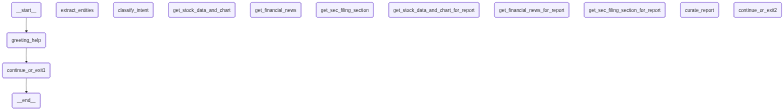

None


In [8]:

from IPython.display import Image, display

try:
    print(display(Image(app.get_graph().draw_mermaid_png())))
except Exception as e:
    print(f"Could not display graph. Error: {e}")


Could not display graph. Error: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [9]:
if __name__ == "__main__":
    
    initial_state = {
        "user_query": None, # The initial state starts with no query
        "messages": [],
        "should_continue": True, # Always True to force the very first execution
        "create_chart": False,
        "company_name": None,
        "ticker": None,
        "filing_type": None,
        "section": None,
        "tool_result": None,
        "structured_data": None,
        "final_answer": None,
        "report_data": None,
        "price_history_json": None,
        "news_results": None,
    }
    

    print("Starting Financial Agent.")
    current_state = app.invoke(initial_state)

    while current_state.get("should_continue", False):
        try:
           
            current_state = app.invoke(current_state)
            
        except Exception as e:
            print(f"\nFATAL ERROR DURING LOOP: {e}")
            break
            
    print("\n--- Session Ended ---")

Starting Financial Agent.
---NODE: Providing Greeting/Help---


                                                                                                                   
  Hello! 😉                                                                                                        
                                                                                                                   
  I am FinSight 💰📈 - your personal Financial Analyst ...                                                         
                                                                                                                   
     Here are some things you can ask me to do 👇                                                                  
     - Generate a stock performance chart for **Amazon (AMZN)**.                                                   
     - What are the risks listed in Microsoft's latest 10-K filing?                                                
     - Summarize recent news about Tesla (TSLA).                                                                   
     - What is the current P/E ratio for NVIDIA (NVDA)?                                                            
     - Generate a full analyst report for Salesforce (CRM).                                                        
                                                                                                                   


--- Awaiting Next Query ---
---FOLLOW-UP ROUTING:  
User wants to continue = 'True' ---
---NODE: Extracting Entities---
Entities extracted: Ticker=AMZN, Filing=None, Section=None and Time Period (default 1y) = 1
---NODE: Classifying Intent---
---Checking INTENT CLASSIFICATION---
---LLM RAW OUTPUT:---
{"step": "get_stock_data_and_chart"}
--------------------
---INFO: Chart flag set to True---
---ROUTING: Intent is 'get_stock_data_and_chart'---


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting Stock Data & Creating Chart                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

┏━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Parameter    ┃ Value  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Ticker       │ AMZN   │
│ Create Chart │ Yes    │
│ Time Period  │ 1 year │
└──────────────┴────────┘

Output()

📅 Data retrieved from 2024-10-02 to 2025-10-02 (251 trading days)

   Key Metrics Retrieved   
┏━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Metric        ┃ Value   ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Current Price │ $222.11 │
│ Market Cap    │ $2.37T  │
│ Pe Ratio      │ 33.91   │
│ Eps           │ $6.55   │
│ 52-Week High  │ $242.52 │
│ 52-Week Low   │ $161.38 │
└───────────────┴─────────┘

Creating price chart for 1 year period...

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Chart created: ./charts/Amazon_1yr_chart_20251003_003500.png                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Success: Successfully fetched 1 year of data for AMZN. Chart saved successfully to                              │
│ ./charts/Amazon_1yr_chart_20251003_003500.png.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


--- Awaiting Next Query ---
---FOLLOW-UP ROUTING:  
User wants to continue = 'True' ---
---NODE: Extracting Entities---
No ticker or company name found.
---NODE: Classifying Intent---
---Checking INTENT CLASSIFICATION---


Task classify_intent with path ('__pregel_pull', 'classify_intent') wrote to unknown channel branch:to:continue_or_exit, ignoring it.


---LLM RAW OUTPUT:---
{"step": "greeting_help"}
--------------------
---ROUTING: Intent is 'greeting_help'---
❗Unexpected intent...routing back to continue_or_exit.
---NODE: Providing Greeting/Help---


                                                                                                                   
  Hello! 😉                                                                                                        
                                                                                                                   
  I am FinSight 💰📈 - your personal Financial Analyst ...                                                         
                                                                                                                   
     Here are some things you can ask me to do 👇                                                                  
     - Generate a stock performance chart for **Amazon (AMZN)**.                                                   
     - What are the risks listed in Microsoft's latest 10-K filing?                                                
     - Summarize recent news about Tesla (TSLA).                                                                   
     - What is the current P/E ratio for NVIDIA (NVDA)?                                                            
     - Generate a full analyst report for Salesforce (CRM).                                                        
                                                                                                                   


--- Awaiting Next Query ---
---FOLLOW-UP ROUTING:  
User wants to EXIT = '{should_continue}' ---

--- Session Ended ---
